In [489]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

In [490]:
weights_w1 = {
    "Energy (kcal)": 4,
    "Sugars (g)": 3,
    "Saturated Fat (g)": 3,
    "Salt (g)": 3,
    "Proteins (g)": 2,
    "Fiber (g)": 2,
    "Fruits_Vegetables (%)": 1,
}

In [491]:
df = pd.read_excel("data-nutri-score-project.xlsx")
cols = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)", "Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)", "Nutri-Score"]

df = df[cols]
df.columns = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)", "Proteins (g)", "Fiber (g)", "Fruits_Vegetables (%)", "Nutri-Score"]
df['Nutri-Score'].describe()
df

,Energy (kcal),Sugars (g),Saturated Fat (g),Salt (g),Proteins (g),Fiber (g),Fruits_Vegetables (%),Nutri-Score
0,462.0,12.0,2.0,0.000,8.5,10.0,10.700000,a
1,388.0,22.4,2.0,0.220,8.8,7.5,0.000000,a
2,362.0,1.7,1.3,0.020,11.0,11.0,0.000000,a
3,372.0,0.7,1.3,0.030,13.5,10.0,0.000000,a
4,362.0,4.4,0.6,0.275,12.0,10.0,0.000000,a
...,...,...,...,...,...,...,...,...
938,334.0,18.0,0.7,0.000,14.0,27.0,0.000000,a
939,0.0,15.7,0.9,0.825,14.1,28.0,0.000000,b
940,392.0,19.9,1.4,0.910,10.3,9.6,0.000000,c
941,452.0,5.8,2.6,0.110,12.0,7.6,25.500000,a


### *Data Exploration*

<Axes: >

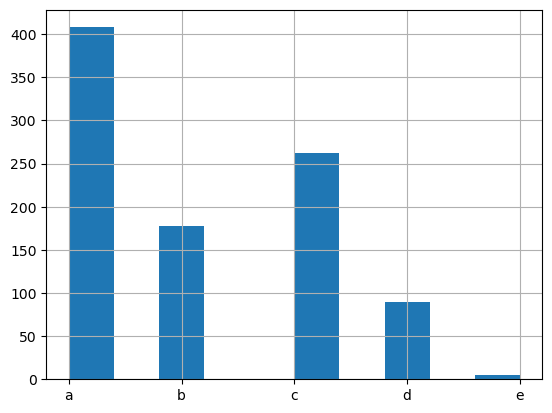

In [492]:
df['Nutri-Score'].hist()

<Axes: ylabel='Frequency'>

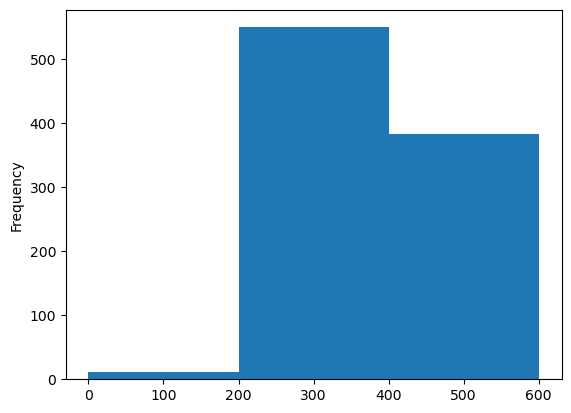

In [493]:
bins = int((df['Energy (kcal)'].max() - df['Energy (kcal)'].min()) / 200)
df['Energy (kcal)'].plot.hist(bins=bins)

<Axes: ylabel='Frequency'>

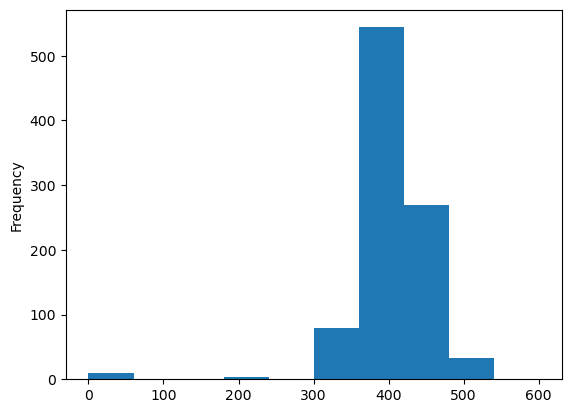

In [494]:
bins = int((df['Saturated Fat (g)'].max() - df['Saturated Fat (g)'].min()) / 2)
df['Energy (kcal)'].plot.hist(bins=bins)

### 1. Create Ranges

In [495]:
def create_ranges(df, criterion, precision, eps):
    num_range = int((df[criterion].max() + eps - df[criterion].min()) / precision)
    real_precision = (df[criterion].max() + eps - df[criterion].min()) / num_range
    ranges = []
    left_thresh = df[criterion].min()
    for i in range(num_range):
        ranges.append((left_thresh, left_thresh + real_precision))
        left_thresh = left_thresh + real_precision

    return ranges

In [496]:
ranges = {}
ranges['Energy (kcal)'] = create_ranges(df, 'Energy (kcal)', precision=200, eps=10)
ranges['Saturated Fat (g)'] = create_ranges(df, 'Saturated Fat (g)', precision=2, eps=0.1)
ranges['Sugars (g)'] = create_ranges(df, 'Sugars (g)', precision=4, eps=0.1)
ranges['Fiber (g)'] = create_ranges(df, 'Fiber (g)', precision=0.7, eps=0.1)
ranges['Proteins (g)'] = create_ranges(df, 'Proteins (g)', precision=2, eps=0.1)
ranges['Salt (g)'] = create_ranges(df, 'Salt (g)', precision=0.2, eps=0.05)
ranges['Fruits_Vegetables (%)'] = create_ranges(df, 'Fruits_Vegetables (%)', precision=10, eps=1)

### 2. Split the dataset

In [497]:
def score_to_numeric(score):
    mapping = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}
    return mapping[score]

def num_to_score(numeric):
    mapping = {5: 'a', 4: 'b', 3: 'c', 2: 'd', 1: 'e'}
    return mapping[numeric]

In [498]:
features = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)", "Proteins (g)", "Fiber (g)", "Fruits_Vegetables (%)", "Nutri-Score"]
df['Nutri-Score'] = df['Nutri-Score'].apply(score_to_numeric)

X = df[features]
y = df[['Nutri-Score']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

df_train = X_train.copy()
df_train['Nutri-Score'] = y_train['Nutri-Score']

df_test = X_test.copy()
df_test['Nutri-Score'] = y_test['Nutri-Score']

### 3. Linear problem

In [499]:
prob = LpProblem("Nutriscore", LpMinimize)
sigma = {i: LpVariable(f"sigma_{i}", 0) for i in df_train.index}

prob += lpSum(sigma.values()), "Minimize errors"
utility_thresh = {key: [LpVariable(f"{key}_{i}", 0, 1) for i in range(len(ranges[key]) + 1)] for key in ranges}

In [500]:
def get_range_index(value, ranges):
    for i, (low, high) in enumerate(ranges):
        if low <= value < high:
            return i
    return len(ranges) - 1

def utility_func(food, utility_thresh, ranges):
    utility = 0
    for criterion in food.index:
        if criterion == 'Nutri-Score':
            continue
        range_idx = get_range_index(food[criterion], ranges[criterion])
        low_util = utility_thresh[criterion][range_idx]
        high_util = utility_thresh[criterion][range_idx + 1]
        range_width = ranges[criterion][range_idx][1] - ranges[criterion][range_idx][0]
        m = (food[criterion] - ranges[criterion][range_idx][0]) / range_width
        utility += low_util + m * (high_util - low_util)
    return utility

In [501]:
for idx, food in df_train.iterrows():
    food_utility = utility_func(food, utility_thresh, ranges)
    for idx2, prec_food in df_train[df_train['Nutri-Score'] < food['Nutri-Score']].iterrows():
        prec_food_utility = utility_func(prec_food, utility_thresh, ranges)
        prob += food_utility + sigma[idx] >= prec_food_utility + sigma[idx2] + 0.001

prob += utility_thresh['Energy (kcal)'][len(utility_thresh['Energy (kcal)'])-1] == 0
prob += utility_thresh['Saturated Fat (g)'][len(utility_thresh['Saturated Fat (g)'])-1] == 0
prob += utility_thresh['Sugars (g)'][len(utility_thresh['Sugars (g)'])-1] == 0
prob += utility_thresh['Salt (g)'][len(utility_thresh['Salt (g)'])-1] == 0
prob += utility_thresh['Proteins (g)'][0] == 0
prob += utility_thresh['Fiber (g)'][0] == 0

# Contraintes de normalisation
prob += utility_thresh['Energy (kcal)'][0] + utility_thresh['Saturated Fat (g)'][0] + utility_thresh['Sugars (g)'][0] + utility_thresh['Salt (g)'][0] + utility_thresh['Proteins (g)'][len(utility_thresh['Proteins (g)'])-1] + utility_thresh['Fiber (g)'][len(utility_thresh['Fiber (g)'])-1] == 1

# Contraintes sur les utilités (croissance/décroissance)
for criterion in ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]:
    for i in range(len(utility_thresh[criterion]) - 1):
        prob += utility_thresh[criterion][i] >= utility_thresh[criterion][i + 1]

for criterion in ["Proteins (g)", "Fiber (g)", "Fruits_Vegetables (%)"]:
    for i in range(len(utility_thresh[criterion]) - 1):
        prob += utility_thresh[criterion][i] <= utility_thresh[criterion][i + 1]

In [502]:
print('Solving the problem...')
prob.solve()
print("Status:", LpStatus[prob.status])

# Extraire les seuils d'utilité
utility_results = {key: [thresh.varValue for thresh in utility_thresh[key]] for key in utility_thresh}

print("Utility thresholds computed:")
for key, values in utility_results.items():
    print(f"{key}: {values}")


Solving the problem...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/melissa/miniconda3/envs/bdma/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d7fbb459775246009501770cc4d497fd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/d7fbb459775246009501770cc4d497fd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11927 COLUMNS
At line 289823 RHS
At line 301746 BOUNDS
At line 301918 ENDATA
Problem MODEL has 11922 rows, 359 columns and 268655 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 11862 (-60) rows, 288 (-71) columns and 256200 (-12455) elements
Perturbing problem by 0.001% of 1.5767935 - largest nonzero change 0.00019851474 ( 4.2455336%) - largest zero change 0.00019380187
0  Obj 0 Primal inf 583.41378 (11751)
50  Obj 0.00045619266 Primal inf 327.48274 (5471)
262  Obj 0.018709163 Primal inf 946.83464 (5615)
443

In [503]:
for criterion in utility_thresh:
    x = [range[0] for range in ranges[criterion]] + [ranges[criterion][-1][1]]
    y = utility_results[criterion]
    plt.plot(x, y, label=criterion)
    plt.title(f'Utility function for {criterion}')
    plt.xlabel('Value')
    plt.ylabel('Utility')
    plt.legend()
    plt.savefig(f'{criterion}_utility_function.jpg')
    plt.clf()

<Figure size 640x480 with 0 Axes>

### 4. Prediction

In [504]:
utility_thresh_prod = {key: [lpVar.varValue for lpVar in utility_thresh[key]]for key in utility_thresh}

In [505]:
def utility_func_prod(df, food_index, utility_thresh):
    food = df.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('Nutri-Score')
    utility = 0
    for criterion in criteria:
        bucket_index = get_range_index(food[criterion], ranges[criterion])
        left_thresh = ranges[criterion][bucket_index][0]
        right_thresh = ranges[criterion][bucket_index][1]
        m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_thresh[criterion][bucket_index]
        right_utility = utility_thresh[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

In [506]:
food_scores = []
for index, food in df_test.iterrows():
  pred = utility_func_prod(df_test, index, utility_thresh_prod)
  nutriscore = num_to_score(food['Nutri-Score'])
  food_scores.append({'Energy (kcal)': food['Energy (kcal)'],
                      'Sugars (g)': food['Sugars (g)'],
                      'Salt (g)': food['Salt (g)'],
                      'Saturated Fat (g)': food['Saturated Fat (g)'],
                      'Proteins (g)': food['Proteins (g)'],
                      'Fiber (g)': food['Fiber (g)'],
                      'Fruits_Vegetables (%)': food['Fruits_Vegetables (%)'],
                      'Nutri-Score': nutriscore, 
                      'Utility_pred': pred
                    })

In [507]:
food_scores.sort(key=lambda food: food['Utility_pred'], reverse=True)
food_scores

[{'Energy (kcal)': 371.0,
  'Sugars (g)': 0.5,
  'Salt (g)': 1.1,
  'Saturated Fat (g)': 0.2,
  'Proteins (g)': 80.0,
  'Fiber (g)': 5.0,
  'Fruits_Vegetables (%)': 0.0,
  'Nutri-Score': 'a',
  'Utility_pred': 17.743197927721337},
 {'Energy (kcal)': 355.0,
  'Sugars (g)': 27.1,
  'Salt (g)': 0.03,
  'Saturated Fat (g)': 0.8,
  'Proteins (g)': 8.0,
  'Fiber (g)': 7.7,
  'Fruits_Vegetables (%)': 56.1875,
  'Nutri-Score': 'b',
  'Utility_pred': 1.5810818978614327},
 {'Energy (kcal)': 320.0,
  'Sugars (g)': 25.0,
  'Salt (g)': 0.0,
  'Saturated Fat (g)': 0.6,
  'Proteins (g)': 8.0,
  'Fiber (g)': 11.0,
  'Fruits_Vegetables (%)': 99.796875,
  'Nutri-Score': 'a',
  'Utility_pred': 1.0960038121652957},
 {'Energy (kcal)': 495.0,
  'Sugars (g)': 4.4,
  'Salt (g)': 0.05,
  'Saturated Fat (g)': 9.2,
  'Proteins (g)': 13.7,
  'Fiber (g)': 12.8,
  'Fruits_Vegetables (%)': 55.25,
  'Nutri-Score': 'c',
  'Utility_pred': 1.0616554862795056},
 {'Energy (kcal)': 363.0,
  'Sugars (g)': 17.5,
  'Salt (g)'

In [508]:
df = pd.DataFrame(food_scores)

csv_file_name = "predictions.csv"
df.to_csv(csv_file_name, index=False)

In [509]:
limiting_profiles = df.groupby('Nutri-Score').agg({
    'Energy (kcal)': 'max',  
    'Sugars (g)': 'max',
    'Salt (g)': 'max',
    'Saturated Fat (g)': 'max',
    'Proteins (g)': 'max',
    'Fiber (g)': 'max',
    'Fruits_Vegetables (%)': "max"
}).reset_index()

limiting_profiles

,Nutri-Score,Energy (kcal),Sugars (g),Salt (g),Saturated Fat (g),Proteins (g),Fiber (g),Fruits_Vegetables (%)
0,a,494.0,25.0,1.1000,4.8,80.0,27.50,99.796875
1,b,508.0,27.1,1.3075,5.0,22.1,27.00,56.187500
2,c,524.0,48.0,2.0000,9.2,27.9,27.00,63.250000
3,d,601.0,39.0,1.4200,20.7,16.0,14.00,70.000000
4,e,534.0,40.0,1.6700,16.0,10.0,7.11,3.071615


In [512]:
limiting_profiles_uta = {}
for _, row in limiting_profiles.iterrows():
    limiting_profiles_uta[row["Nutri-Score"].upper()] = {
        "Energy (kcal)": row["Energy (kcal)"],
        "Sugars (g)": row["Sugars (g)"],
        "Salt (g)": row["Salt (g)"],
        "Saturated Fat (g)": row["Saturated Fat (g)"],
        "Proteins (g)": row["Proteins (g)"],
        "Fiber (g)": row["Fiber (g)"],
        "Fruits/Vegetables (%)": row["Fruits_Vegetables (%)"],
    }

file_path = "limiting_profiles_uta.json"
with open(file_path, "w") as file:
    json.dump(limiting_profiles_uta, file, indent=4)